## Submission for BHI 2023 Public Health Informatics Data Competition
*CAN US aggregate timeseries dataset*

#### Imports

In [252]:
import pandas as pd
import torch
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import math

#### Load Dataframes & Sub-set Data

In [253]:
df = pd.read_csv("../data/US.timeseries.csv", usecols=["date", "actuals.newCases"], index_col="date", parse_dates=True)

df = df.fillna(method="bfill")

df = df[df.index < '2021-10-03']

df

,actuals.newCases
date,
2020-03-09,403.0
2020-03-10,403.0
2020-03-11,403.0
2020-03-12,403.0
2020-03-13,542.0
...,...
2021-09-28,113340.0
2021-09-29,128470.0
2021-09-30,115704.0


#### Plot time-series

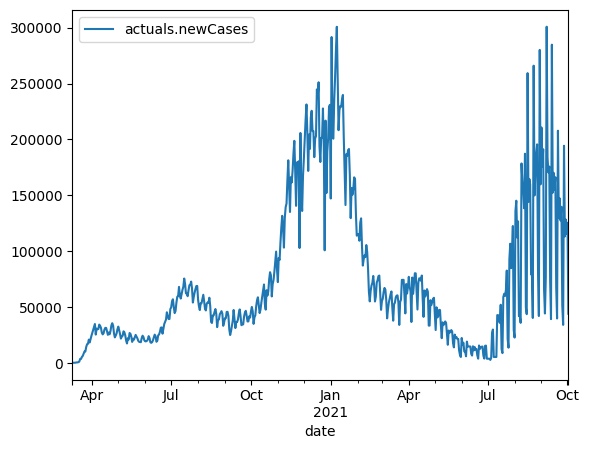

In [254]:
df.plot()

plt.show()

### Normalize using MinMaxScaler

In [255]:
scaler = MinMaxScaler(feature_range=(-1, 1))
df['actuals.newCases'] = scaler.fit_transform(df['actuals.newCases'].values.reshape(-1, 1))

df

,actuals.newCases
date,
2020-03-09,-1.000000
2020-03-10,-1.000000
2020-03-11,-1.000000
2020-03-12,-1.000000
2020-03-13,-0.999075
...,...
2021-09-28,-0.248149
2021-09-29,-0.147425
2021-09-30,-0.232412


### Look-back function

In [337]:
import numpy as np

# function to create train, test data given stock data and sequence length
def load_data(data, look_back):
    data_raw = data.values # convert to numpy array
    data = []
    
    # create all possible sequences of length look_back
    for index in range(len(data_raw) - look_back): 
        data.append(data_raw[index: index + look_back])
    
    data = np.array(data)
    test_set_size = 7
    train_set_size = data.shape[0] - test_set_size
    
    x_train = data[:train_set_size,:-1,:]
    y_train = data[:train_set_size,-1,:]
    
    x_test = data[train_set_size:,:-1]
    y_test = data[train_set_size:,-1,:]
    
    return [torch.Tensor(x_train), torch.Tensor(y_train), torch.Tensor(x_test), torch.Tensor(y_test)]

look_back = 30 # choose sequence length
X_train, y_train, X_test, y_test = load_data(df, look_back)
print('x_train.shape = ',X_train.shape)
print('y_train.shape = ',y_train.shape)
print('x_train.shape = ',X_test.shape)
print('y_train.shape = ',y_test.shape)


x_train.shape =  torch.Size([536, 29, 1])
y_train.shape =  torch.Size([536, 1])
x_train.shape =  torch.Size([7, 29, 1])
y_train.shape =  torch.Size([7, 1])


#### LTSM Neural Network Definition

In [338]:
import torch.nn as nn

# Here we define our model as a class
class LSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
        super(LSTM, self).__init__()
        # Hidden dimensions
        self.hidden_dim = hidden_dim

        # Number of hidden layers
        self.num_layers = num_layers

        # batch_first=True causes input/output tensors to be of shape
        # (batch_dim, seq_dim, feature_dim)
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)

        # Readout layer
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        # Initialize hidden state with zeros
        
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_()
        h0 = h0.to(mps)
        
        # Initialize cell state
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_()
        c0 = c0.to(mps)
        
        # We need to detach as we are doing truncated backpropagation through time (BPTT)
        # If we don't, we'll backprop all the way to the start even after going through another batch
        out, (hn, cn) = self.lstm(x, (h0.detach(), c0.detach()))

        # Index hidden state of last time step
        # out.size() --> 100, 32, 100
        # out[:, -1, :] --> 100, 100 --> just want last time step hidden states! 
        out = self.fc(out[:, -1, :]) 
        # out.size() --> 100, 10
        return out

#### Training Loop

Epoch 0 - MSE: 0.32504284381866455
Epoch 10 - MSE: 0.08369478583335876
Epoch 20 - MSE: 0.04226406291127205
Epoch 30 - MSE: 0.04006090387701988
Epoch 40 - MSE: 0.039221156388521194
Epoch 50 - MSE: 0.039096374064683914
Epoch 60 - MSE: 0.03856688737869263
Epoch 70 - MSE: 0.03828888386487961
Epoch 80 - MSE: 0.038077253848314285
Epoch 90 - MSE: 0.03791051730513573
Epoch 100 - MSE: 0.037744782865047455


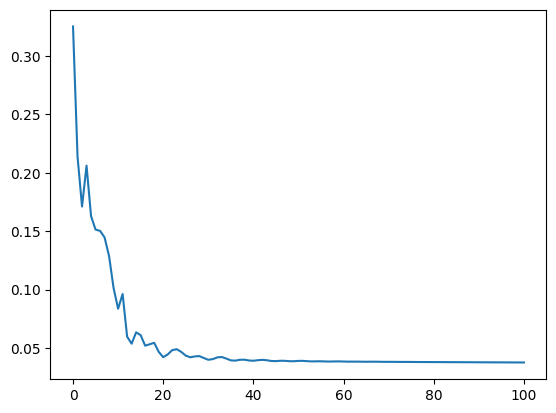

In [339]:

import numpy as np
import torch.optim as optim
import torch.utils.data as data

X_train = X_train.to(mps)
y_train = y_train.to(mps)

X_test = X_test.to(mps)
y_test = y_test.to(mps)
    
def train(hidden_dims, num_layers, n_epochs, lr):
    
    model = LSTM(input_dim=1, hidden_dim=hidden_dims, output_dim=1, num_layers=num_layers)

    mps = torch.device('mps')

    model.to(mps)

    optimizer = optim.Adam(model.parameters(), lr)
    loss_fn = nn.MSELoss()
    
    hist = np.zeros(n_epochs)
    
    for epoch in range(n_epochs):
        model.train()
        
        y_pred = model(X_train)
        loss = loss_fn(y_pred, y_train)
        hist[epoch] = loss.item()
        
        if epoch % 10 == 0:
            print(f"Epoch {epoch} - MSE: {loss.item()}")
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        # Validation
        
    return hist

hist = train(32, 2, 101, 0.01)
plt.plot(hist)
plt.show()

### Testing on week of 9/27

In [340]:
with torch.no_grad():
    y_train_pred = model(X_train)
    y_test_pred = model(X_test)
    
    y_train_pred = scaler.inverse_transform(y_train_pred.detach().cpu().numpy())[:, 0]
    y_train_real = scaler.inverse_transform(y_train.detach().cpu().numpy())[:, 0]
    y_test_pred = scaler.inverse_transform(y_test_pred.detach().cpu().numpy())[:, 0]
    y_test_real = scaler.inverse_transform(y_test.detach().cpu().numpy())[:, 0]
    
    train_rsme = np.sqrt(mean_squared_error(y_train_real, y_train_pred))
    train_mae = np.mean(abs(y_train_pred - y_train_real))
    test_rsme = np.sqrt(mean_squared_error(y_test_real, y_test_pred))
    test_mae = np.mean(abs(y_test_pred - y_test_real))
        
print(f"Train RSME: {train_rsme}, Train MAE: {train_mae} Test RSME: {test_rsme}, Test MAE: {test_mae}")


Train RSME: 28340.224609375, Train MAE: 16013.8359375 Test RSME: 53528.0390625, Test MAE: 44247.80078125


### Historical Predictions for 8/30/2021 - 9/26/2021

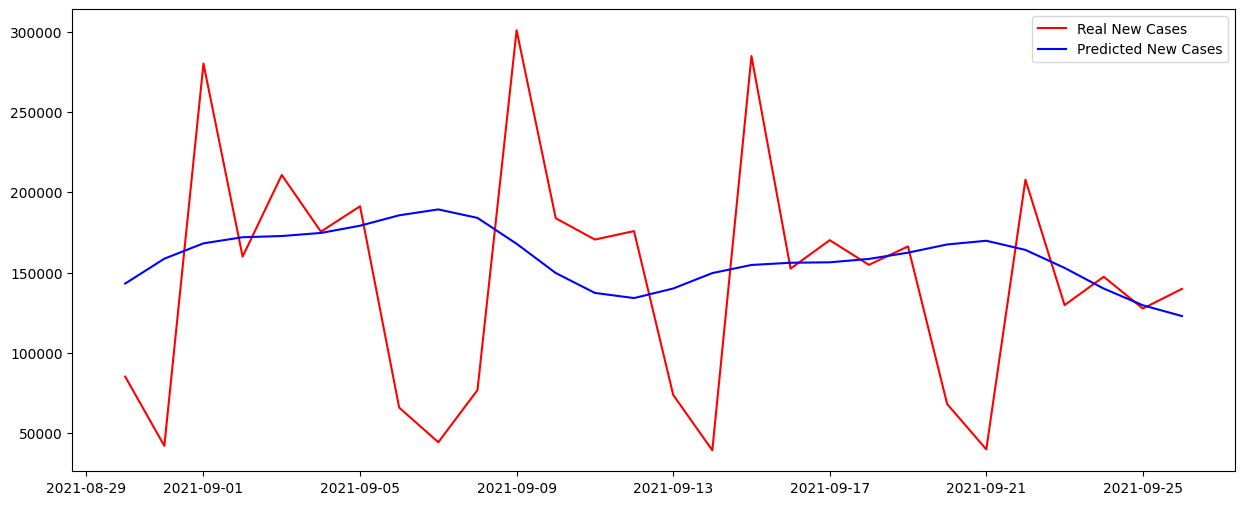

8/30/21 - 9/26/21: RSME - 28340.224609375, MAE 16013.8359375


In [344]:
figure, axes = plt.subplots(figsize=(15, 6))
axes.xaxis_date()

## 30 day historical period

df_hist = df.loc['2021-08-30':'2021-09-26']
y_train_real_hist = y_train_real[len(y_train_real) - len(df_hist):]
y_train_pred_hist = y_train_pred[len(y_train_pred) - len(df_hist):]

axes.plot(df_hist.index, y_train_real_hist, color = 'red', label = 'Real New Cases')
axes.plot(df_hist.index, y_train_pred_hist, color = 'blue', label = 'Predicted New Cases')

plt.legend()
plt.show()

rsme = np.sqrt(mean_squared_error(y_train_real_hist, y_train_pred_hist))
mae = np.mean(abs(y_train_pred_hist - y_train_real_hist))

print(f"8/30/21 - 9/26/21: RSME - {train_rsme}, MAE {train_mae}")

### Test Predictions 09/27/2021 - 10/03/2021

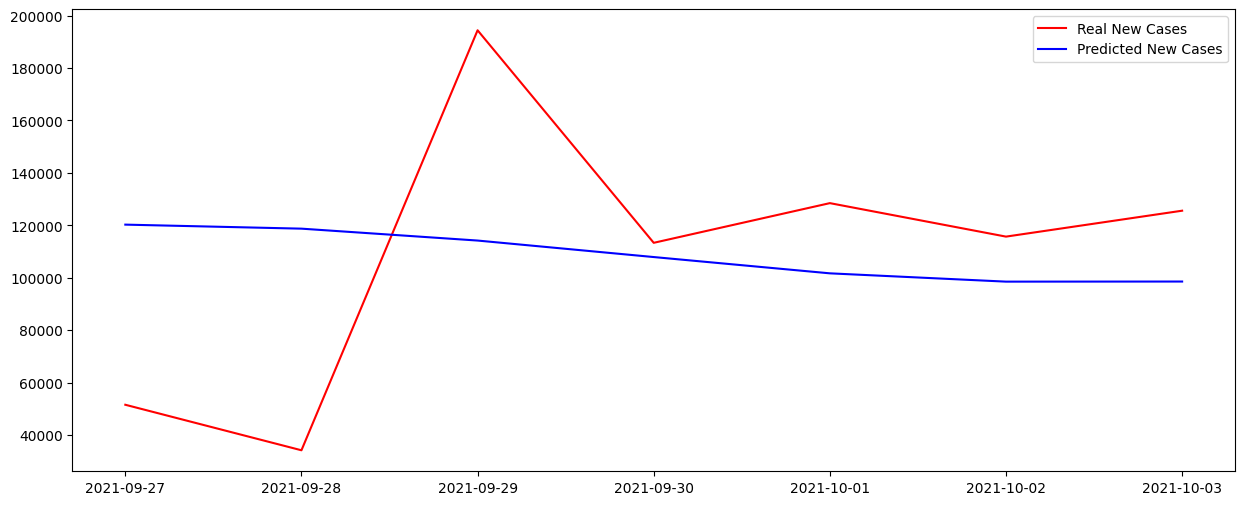

09/27/21 - 10/03/21: RSME - 28340.224609375, MAE 16013.8359375


,predicted,ground truth,absolute error
2021-09-27,120274.460938,51591.996094,68682.468750
2021-09-28,118739.328125,34235.003906,84504.328125
2021-09-29,114202.054688,194379.000000,80176.945312
2021-09-30,107912.265625,113340.000000,5427.734375
2021-10-01,101702.406250,128470.007812,26767.601562
2021-10-02,98538.078125,115704.000000,17165.921875
2021-10-03,98574.406250,125583.992188,27009.585938


In [350]:
date_range = pd.date_range('2021-09-27', '2021-10-03')
df_test = pd.DataFrame(index=date_range)

df_test['predicted'] = pd.DataFrame(y_test_pred, index=date_range)
df_test['ground truth'] = pd.DataFrame(y_test_real, index=date_range)
df_test['absolute error'] = abs(df_test['predicted'] - df_test['ground truth'])

figure, axes = plt.subplots(figsize=(15, 6))
axes.xaxis_date()

axes.plot(df_test.index, df_test["ground truth"], color = 'red', label = 'Real New Cases')
axes.plot(df_test.index, df_test["predicted"], color = 'blue', label = 'Predicted New Cases')

plt.legend()
plt.show()

rsme = np.sqrt(mean_squared_error(df_test["ground truth"], df_test["predicted"]))
mae = np.mean(abs(df_test["predicted"] - df_test["ground truth"]))

print(f"09/27/21 - 10/03/21: RSME - {train_rsme}, MAE {train_mae}")

df_test